# Bonus1: Parallel Algorithms

### Name: Amir Morcos


## 0. You will do the following:

1. Read the lecture note: [click here](https://github.com/wangshusen/DeepLearning/blob/master/LectureNotes/Parallel/Parallel.pdf)

2. Implement federated averaging or decentralized optimization.

3. Plot the convergence curve. (The x-axis can be ```number of epochs``` or ```number of communication```. You must make sure the label is correct.)

4. Convert the .IPYNB file to .HTML file.

    * The HTML file must contain **the code** and **the output after execution**.
    
5. Upload this .HTML file to your Google Drive, Dropbox, or your Github repo. (If it is submitted to Google Drive or Dropbox, you must make the file open-access.)

6. Submit the link to this .HTML file to Canvas.

    * Example: https://github.com/wangshusen/CS583-2020S/blob/master/homework/Bonus1/Bonus1.html



# 1. Data processing

- Download the Diabete dataset from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/diabetes
- Load the data using sklearn.
- Preprocess the data.

## 1.1. Load the data

In [1]:
from sklearn import datasets
import numpy

x_sparse, y = datasets.load_svmlight_file('diabetes')
x = x_sparse.todense()

print('Shape of x: ' + str(x.shape))
print('Shape of y: ' + str(y.shape))

Shape of x: (768, 8)
Shape of y: (768,)


## 1.2. Partition to training and test sets

In [2]:
# partition the data to training and test sets
n = x.shape[0]
n_train = 640
n_test = n - n_train

rand_indices = numpy.random.permutation(n)
train_indices = rand_indices[0:n_train]
test_indices = rand_indices[n_train:n]

x_train = x[train_indices, :]
x_test = x[test_indices, :]
y_train = y[train_indices].reshape(n_train, 1)
y_test = y[test_indices].reshape(n_test, 1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))
print('Shape of y_train: ' + str(y_train.shape))
print('Shape of y_test: ' + str(y_test.shape))

Shape of x_train: (640, 8)
Shape of x_test: (128, 8)
Shape of y_train: (640, 1)
Shape of y_test: (128, 1)


## 1.3. Feature scaling

Use the standardization to trainsform both training and test features

In [3]:
# Standardization
import numpy

# calculate mu and sig using the training set
d = x_train.shape[1]
mu = numpy.mean(x_train, axis=0).reshape(1, d)
sig = numpy.std(x_train, axis=0).reshape(1, d)

# transform the training features
x_train = (x_train - mu) / (sig + 1E-6)

# transform the test features
x_test = (x_test - mu) / (sig + 1E-6)

print('test mean = ')
print(numpy.mean(x_test, axis=0))

print('test std = ')
print(numpy.std(x_test, axis=0))

test mean = 
[[-0.11841348 -0.02213439 -0.03502406 -0.10505703  0.00194138 -0.01444808
  -0.16757771 -0.08180074]]
test std = 
[[0.90186548 0.82740408 1.1415064  1.06111473 1.04543779 1.14007165
  0.76079621 0.92009536]]


## 1.4. Add a dimension of all ones

In [4]:
n_train, d = x_train.shape
x_train = numpy.concatenate((x_train, numpy.ones((n_train, 1))), axis=1)

n_test, d = x_test.shape
x_test = numpy.concatenate((x_test, numpy.ones((n_test, 1))), axis=1)

print('Shape of x_train: ' + str(x_train.shape))
print('Shape of x_test: ' + str(x_test.shape))

Shape of x_train: (640, 9)
Shape of x_test: (128, 9)


In [5]:
class Worker:
    def __init__(self,x,y,q=1, alpha = 1E-1, beta = 0.9, lam = 1E-6):
        self.x=x#s-by-d local feature matrix
        self.y=y#s-by-1 local label matrix
        self.s=x.shape[0]#number of local samples
        self.d=x.shape[1]#number of features
        self.w=numpy.zeros((self.d,1))#d-by-1 model parameter vector
        self.mw=numpy.zeros((self.d,1))#d-by-1 model parameter vector
        self.v=numpy.zeros((self.d,1))#d x 1 momentum
        
        #self.v=0#d x 1 momentum
        self.q = q
        self.alpha = alpha
        self.beta = beta
        
        
#Set the model parameters to the latest
    def set_param(self,w):
        self.w=w

#Compute the local loss
    def loss(self):
        yx=numpy.multiply(self.y,self.x)#s-by-d matrix
        yxw=numpy.dot(yx,self.mw)#s-by-1 matrix
        vec1=numpy.exp(-yxw)#s-by-1 matrix
        vec2=numpy.log(1+vec1)#s x 1 matrix
        return numpy.sum(vec2)#loss function

#Compute the local gradient
    def gradient(self):
        self.mw = numpy.copy(self.w)
        
        for f in range(self.q):
            
            yx=numpy.multiply(self.y,self.x)#s x d matrix
            yxw=numpy.dot(yx,self.mw)#s x1 matrix
            vec1=numpy.exp(yxw)#s x 1 matrix
            vec2=numpy.divide(yx,1+vec1)#s xd matrix
            g=-numpy.sum(vec2,axis=0).reshape(self.d,1)#d x 1 matrix

            lg=g/self.s+lam*self.mw
            self.v*=beta
            self.v+=lg
            self.mw-=alpha*self.v
            
        return g

In [6]:
class Server:
    def __init__(self,m,n,d):
        self.m=m #number of workernodes
        self.n=n #number of training samples
        self.d=d #number of features
        self.w=numpy.zeros((d,1))#d x 1 model parameter vector
        self.g=numpy.zeros((d,1))#d x 1 gradient
        self.v=numpy.zeros((d,1))#d x 1 momentum
        self.loss=0 #loss function value
        self.obj=0 #objective function value

    def broadcast(self):
        return self.w

    #Sum the gradients and loss function evaluated by the workers
    #Args:
    #grads:a list of d x 1 vectors
    #losses:a list of scalars
    def aggregate(self,grads,losses):
        self.g=numpy.zeros((self.d,1))
        self.loss=0
        for k in range(self.m):
            self.g+=grads[k]
            self.loss+=losses[k]

    #Compute the gradient (from the loss and regularization)
    def gradient(self,lam):
        self.g=self.g/self.n+lam*self.w

    #Compute the objective function (sum of loss and regularization)
    def objective(self,lam):
        reg=lam/2*numpy.sum(self.w*self.w)
        self.obj=self.loss/self.n+reg
        return self.obj

    #Update the model parameters using accelerated gradient descent
    #Args:
    #alpha:learning rate(stepsize)
    #beta:momentum parameter
    def agd(self,alpha,beta):
        self.v*=beta
        self.v+=self.g
        self.w-=alpha*self.v


In [7]:
import math

#Create a server and m worker nodes
def create_server_workers(m,x,y,q):
    n,d=x.shape
    s=math.floor(n/m)
    server=Server(m,n,d)
    workers=[]

    for i in range(m):
        indices=list(range(i*s,(i+1)*s))
        worker=Worker(x[indices,:],y[indices,:],q)
        workers.append(worker)

    return server, workers

In [8]:
m=4 #number of worker nodes
server,workers=create_server_workers(m,x_train,y_train,1)

In [9]:
lam=1E-6 #regularization parameter
alpha=1E-1 #learning rate
beta=0.9 #momentum parameter
max_epoch=50 #number of epochs
PAGD = []
for t in range(max_epoch):
#step1:broadcast
    w=server.broadcast()
    for i in range(m):
        workers[i].set_param(w)

    #step2:workers'localcomputations
    grads=[]
    losses=[]
    for i in range(m):
        g=workers[i].gradient()
        grads.append(g)
        l=workers[i].loss()
        losses.append(l)

    #step3:aggregate the workers' outputs
    server.aggregate(grads,losses)

    #step4:server update the model parameters
    server.gradient(lam)#computegradient
    obj=server.objective(lam)#compute objective function
    #print('Objectivefunctionvalue='+str(obj))
    PAGD.append(obj)
    server.agd(alpha,beta)#updates the model parameters


In [10]:
m=4 #number of worker nodes
server,workers=create_server_workers(m,x_train,y_train,5)

In [11]:
FDAFG = []
for t in range(max_epoch):
#step1:broadcast
    w=server.broadcast()
    for i in range(m):
        workers[i].set_param(w)

    #step2:workers'localcomputations
    grads=[]
    losses=[]
    for i in range(m):
        g=workers[i].gradient()
        grads.append(g)
        l=workers[i].loss()
        losses.append(l)

    #step3:aggregate the workers' outputs
    server.aggregate(grads,losses)

    #step4:server update the model parameters
    server.gradient(lam)#computegradient
    obj=server.objective(lam)#compute objective function
    #print('Objectivefunctionvalue='+str(obj))
    FDAFG.append(obj)
    server.agd(alpha,beta)#updates the model parameters


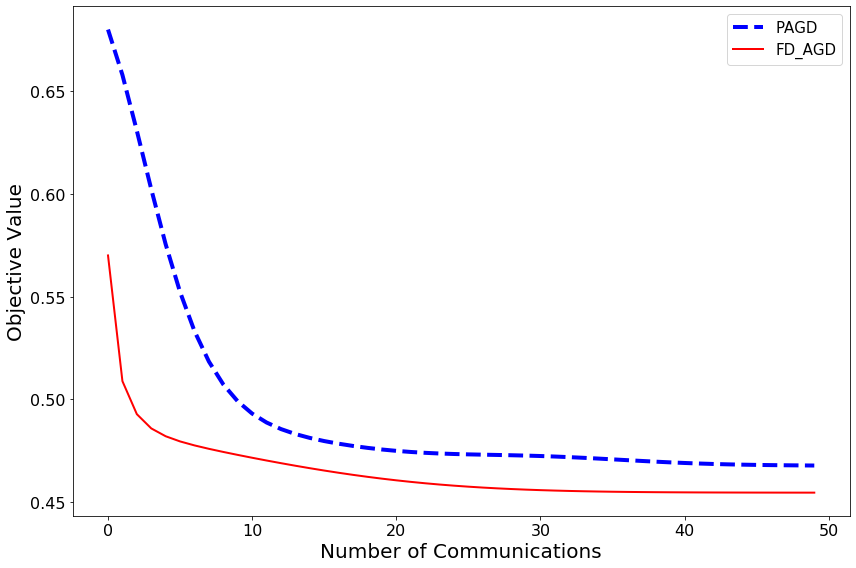

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot the 2 curves:
fig = plt.figure(figsize=(12, 8))

Comm_PAGD = range(len(PAGD))
Comm_FDAFG = range(len(FDAFG))


line0, = plt.plot(Comm_PAGD, PAGD, '--b', LineWidth=4)
line1, = plt.plot(Comm_FDAFG, FDAFG, '-r', LineWidth=2)

plt.xlabel('Number of Communications', FontSize=20)
plt.ylabel('Objective Value', FontSize=20)
plt.xticks(FontSize=16)
plt.yticks(FontSize=16)
plt.legend([line0, line1], ['PAGD', 'FD_AGD'], fontsize=15)
plt.tight_layout()
plt.show()
fig.savefig('compare_PAGD_FD_AGD.pdf', format='pdf', dpi=1200)